#### Charging and Discharging of a Capacitor in an RC Circuit

The RC circuit consists of a resistor R and a capacitor C in series, connected to a voltage source. The task for the PINN is to model the voltage across the capacitor as a function of time, constrained by the governing differential equation.

$ RC.\frac{dV_C(t)}{dt} + V_c(t) = V(t) $<br><br>



Initial Condition:

    For charging, we assume the capacitor starts with no charge, so the voltage across the capacitor at t=0 is VC(0)=0.

Physics Loss:

    The physics loss is based on the governing first-order differential equation for an RC circuit, which describes how the voltage VC(t) evolves as a function of time during the charging process.

Input Voltage:

    In this example, we assume a step input voltage $ V(t)=V0 $, meaning the voltage suddenly switches to a constant value at t=0.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import matplotlib.pyplot as  plt
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
print(torch.__version__)

2.7.0+cu128


In [4]:
# Define the Physics-Informed Neural Network (PINN)
class PINN_RC(nn.Module):
    def __init__(self):
        super(PINN_RC, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Input is time t
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)  # Output is the voltage V_C(t)
    
    def forward(self, t):
        x = torch.relu(self.fc1(t))
        x = torch.relu(self.fc2(x))
        voltage = self.fc3(x)
        return voltage

In [5]:
# Define the governing RC equation parameters
R = 1.0  # Resistance in Ohms
C = 0.01  # Capacitance in Farads
V0 = 5.0  # Step input voltage in Volts

In [6]:
# Define the input voltage function V(t) for charging (step input)
def V(t):
    return V0  # Step function voltage V0 for t >= 0

# Define the Physics-Informed Loss function
def physics_loss(model, t):
    # Predict the voltage across the capacitor V_C(t)
    V_C_pred = model(t)
    
    # Compute dV_C/dt using autograd
    V_C_t = torch.autograd.grad(V_C_pred, t, grad_outputs=torch.ones_like(V_C_pred), create_graph=True)[0]
    
    # Physics-informed loss (residual of the RC equation)
    residual = R * C * V_C_t + V_C_pred - V(t)
    physics_loss = torch.mean(residual**2)
    return physics_loss

# Define initial condition loss for charging
def initial_condition_loss(model):
    t0 = torch.tensor([[0.0]], requires_grad=True)  # Time t = 0
    V_C_pred = model(t0)
    return torch.mean((V_C_pred - 0)**2)  # Initial voltage V_C(0) = 0

# Train the PINN model
def train_PINN(model, epochs=5000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Generate random time samples for training
        t = torch.rand(100, 1) * 10  # Random time samples between 0 and 10
        
        # Enable autograd for t (needed to compute derivatives)
        t.requires_grad = True

        # Compute total loss (physics + initial condition)
        loss = physics_loss(model, t) + initial_condition_loss(model)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')




In [7]:
# Main function to run the model

pinn = PINN_RC()

# Train the model
train_PINN(pinn, epochs=5000)

Epoch 0, Loss: 26.706464767456055
Epoch 500, Loss: 0.011505551636219025
Epoch 1000, Loss: 0.04098980501294136
Epoch 1500, Loss: 0.007166330236941576
Epoch 2000, Loss: 0.0012573497369885445
Epoch 2500, Loss: 0.0008127643959596753
Epoch 3000, Loss: 0.00029672111850231886
Epoch 3500, Loss: 0.0027630485128611326
Epoch 4000, Loss: 0.007273782975971699
Epoch 4500, Loss: 0.11332442611455917


#### Let us plot and see if the capacitor charging to V is simulated

In [8]:
# Consider time t=0 to t=0.2 and use the trained PINN to predict Voltage values

inp = []
out = []
for i in range(0,20):
    inp.append(i/100)
    with torch.no_grad():
        i = torch.tensor([i/100]).float()
        o = pinn(i)
        o = o.numpy()
        out.append(o)

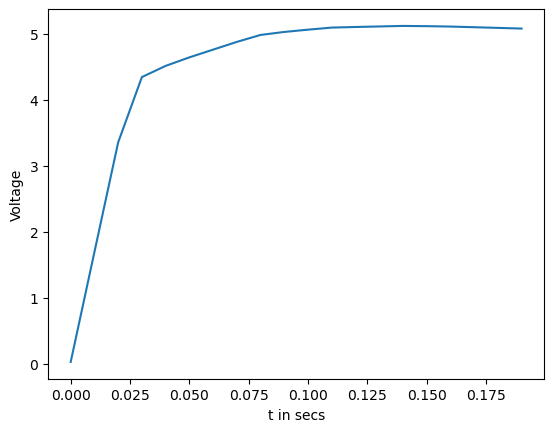

In [9]:
# Plot the function

plt.plot(inp,out)

plt.xlabel('t in secs')
plt.ylabel('Voltage')

plt.show()